# RESNET50

In [180]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [181]:
# === 1. Paths ===
DATA_DIR = r'C:\Users\User\Desktop\deeplearning\dataset_split\sample'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

In [182]:
# === 2. Image Parameters ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

In [183]:
# === 3. Image Data Generators ===
train_ds = image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = image_dataset_from_directory(
    VAL_DIR,
    label_mode='categorical',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
test_ds = image_dataset_from_directory(
    TEST_DIR,
    label_mode='categorical',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2020 files belonging to 202 classes.
Found 1338 files belonging to 202 classes.
Found 1312 files belonging to 202 classes.


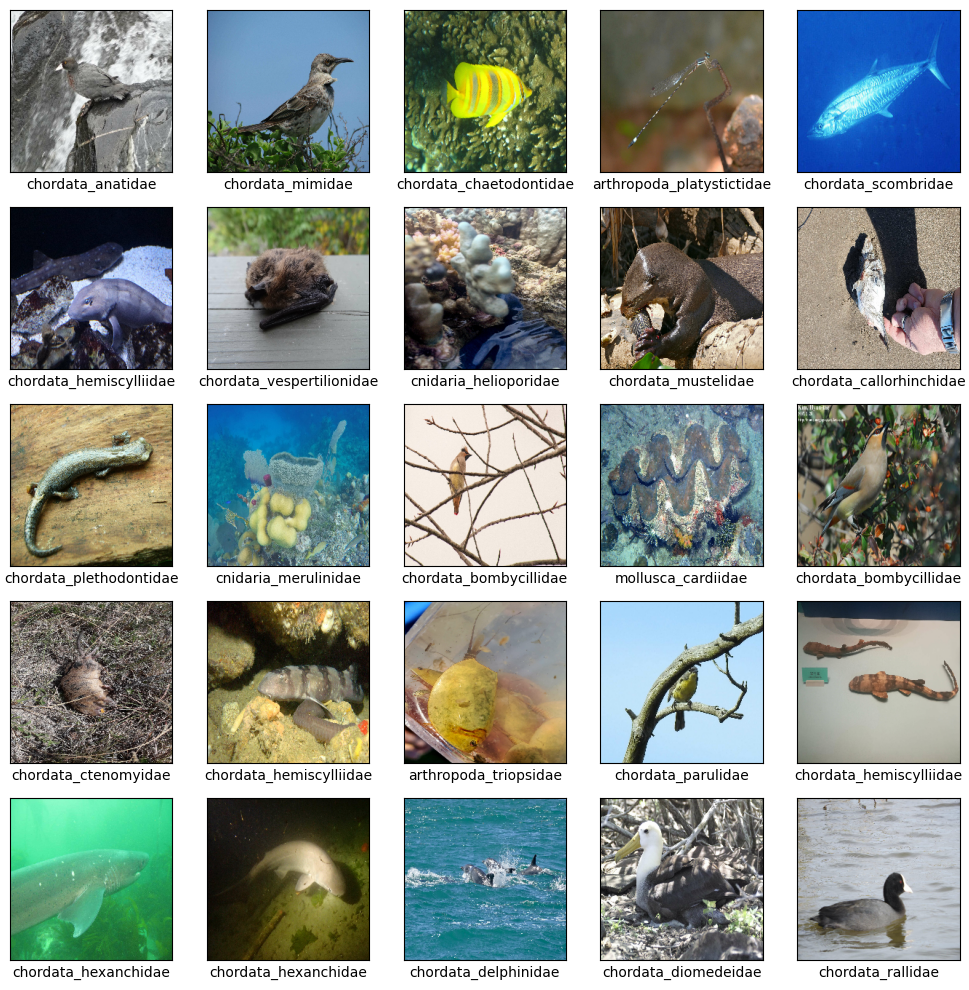

In [184]:
# Pega um batch de imagens e labels
images, labels = next(iter(train_ds))

# Pega nomes das classes
label_names = train_ds.class_names

# Plotar 25 imagens do batch
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    img = images[i].numpy().astype("uint8")
    label = np.argmax(labels[i])  # converte one-hot para índice
    plt.xlabel(label_names[label])
    plt.imshow(img)
plt.tight_layout()
plt.show()


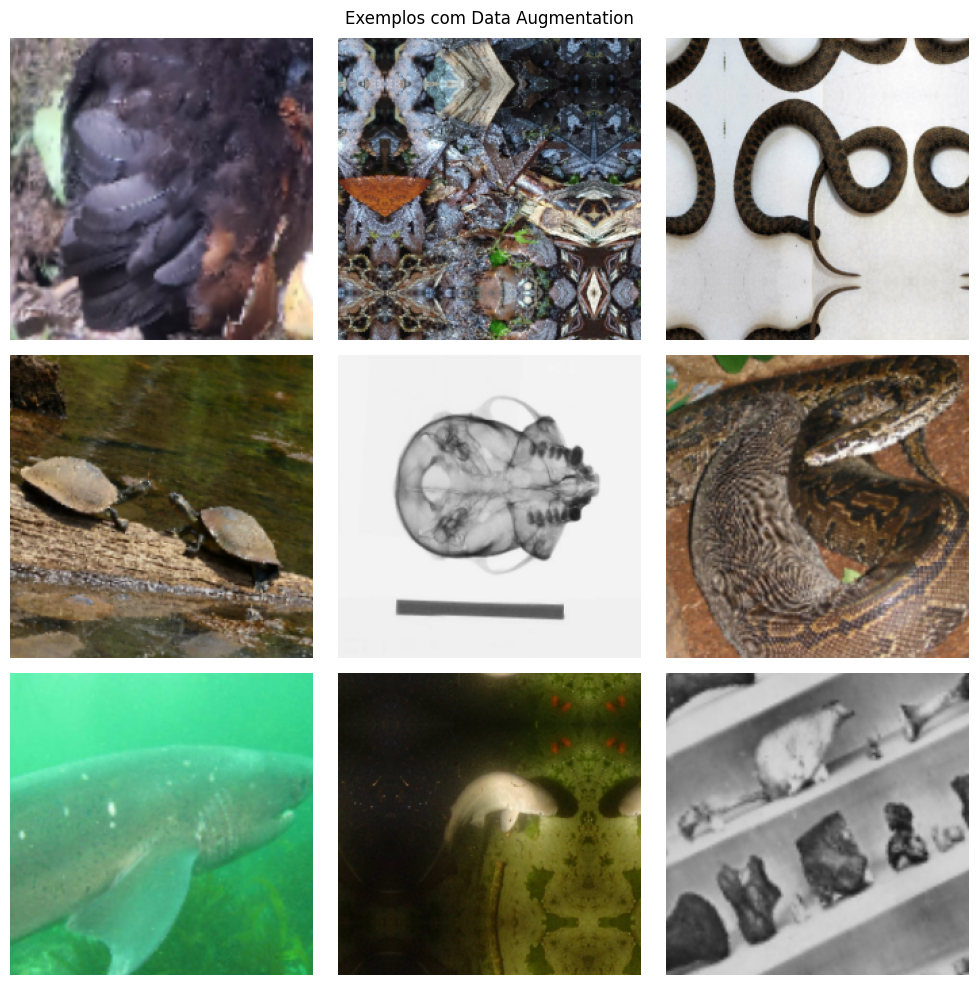

In [185]:
import matplotlib.pyplot as plt

sample_batch = next(iter(train_ds))
augmented_batch = data_augmentation(sample_batch[0])

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow((augmented_batch[i].numpy() * 255).astype("uint8"))
    plt.axis('off')
plt.suptitle("Exemplos com Data Augmentation")
plt.tight_layout()
plt.show()


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),  # só flip horizontal
    tf.keras.layers.RandomRotation(0.1),      # mais leve
    tf.keras.layers.RandomZoom(0.7),           # zoom mínimo
    #tf.keras.layers.RandomContrast(0.1),       # mantém detalhe
])



val_ds = val_ds.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))
test_ds = test_ds.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))


In [186]:
# === 5. Descobrir número de classes ===
num_classes = len(train_ds.class_names)
print(num_classes)

202


In [187]:
from tensorflow.keras import applications
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
import keras


In [188]:
vgg_base = applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
vgg_base.trainable = False

In [178]:
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = vgg_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.7)(x)
outputs = layers.Dense(num_classes, activation='sigmoid')(x)

vgg_model = Model(inputs, outputs)
vgg_model.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_20 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 202)            │        26,058 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,806,410 (56.48 MB)

 Trainable params: 91,722 (358.29 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [189]:
vgg_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [190]:
epochs = 25
vgg_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25


c:\Users\User\anaconda3\envs\dl\Lib\site-packages\keras\src\backend\tensorflow\nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


64/64 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - categorical_accuracy: 0.0044 - loss: 5.5805 - val_categorical_accuracy: 0.0075 - val_loss: 5.4247
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - categorical_accuracy: 0.0122 - loss: 5.4058 - val_categorical_accuracy: 0.0075 - val_loss: 5.3959
Epoch 3/25
54/64 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - categorical_accuracy: 0.0026 - loss: 5.3734

KeyboardInterrupt: 